In [8]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
import numpy as np
from google.colab.patches import cv2_imshow
from numpy.core.fromnumeric import prod
import cv2
import os

In [10]:
#Move to the notebook working directory
%cd /content/gdrive/MyDrive/Bioimage Informatics

#Make directories for training and test data from domain A (real data) and domain B(synthetic data)
%mkdir -p Image\ Synthesis/trainA
%mkdir -p Image\ Synthesis/trainB

%mkdir -p Image\ Synthesis/testA
%mkdir -p Image\ Synthesis/testB

/content/gdrive/.shortcut-targets-by-id/1KBLLeRYGQsIfkELFrExLiWHh1WVbHC7P/Bioimage Informatics


## Generating Syntethic Data

In [11]:
#obtained from the .nd2 image meta data
pixW = 474
pixH = 474
pixelSize = 0.1066667 #microns

np.random.seed(42)

##Helper Functions

In [12]:
def initialize_parameters():
  #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4227890/#:~:text=We%20determined%20the%20nuclear%20dimensions,height%20(n%20%3D%2060).
  #Used above reference for the nucleus axes mean/std
  nucAx1 = (16,2) #mean,std - microns
  nucAx2 = (23,3) #mean,std - microns


  nucParams = np.array([nucAx1,nucAx2])

  #Values from 'descriptions.csv' Will sent me 
  dropletParams = [[77.47,21.19]] #mean, std - #of droplets


  meanVolume = 0.210997691088744 #um^3
  stdVolume = 0.0763824501005185 #um^3

  #Assume sphereical droplets so V = (4/3) * pi * r^3
  dropRadiusMean = (meanVolume * (3/(4 * np.pi)) )**(1/3) *(2/3)
  dropRadiStd = (stdVolume * (3/(4 * np.pi)) )**(1/3) *(2/3)


  dropletParams.append([dropRadiusMean,dropRadiStd])
  dropletParams = np.array(dropletParams)

  return dropletParams, nucParams


#Convert the parameters whose units are in um to pixels
def convert_um_to_pixels(arr,pixelSize):
    return (arr/pixelSize).astype(int)


def save_generated_images(imgList,outPath):
  for i,img in enumerate(imgList):
  
    #obtain the correct file label
      label = str(i)
      if len(str(i)) == 1:
          label = '00' + label
      elif len(str(i)) == 2:
          label = '0' + label
      cv2.imwrite(outPath + f"synth_{i}.jpg",img)

#Add gaussian noise
def add_image_noise(img):
  scalingFactor = 10
  noise = np.random.normal(size = prod(img.shape)) * scalingFactor
  noise = noise.reshape(img.shape)
  img = img + noise

  return img

Domain Randomization <br>
-Number of droplets sampled within the ellipse uniformly from 0 - mean + std*3 <br>
-Bounding box axes sampled randomly from uniform  larger variance?


In [13]:
def domain_randomize(dropletParams,nucParams):
    dropletParams[0] = ([np.random.randint(0,141),0]) #Sample uniformly from 0 - 3*std of number of droplets

    nucParams[0] = np.array([12,20])
    nucParams[1] = np.array([17,29])

    ax1 = np.random.uniform(nucParams[0][0],nucParams[0][1])
    ax2 = np.random.uniform(nucParams[1][0],nucParams[1][1])


    return dropletParams, np.array([ax1,ax2])

## Bezier Code

In [14]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt


bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a

def get_random_points(points,n=4, scale=1, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst #or .7/n

    idxs = np.random.choice(np.arange(0,len(points)),size = n , replace= False)
    a = points[idxs]

    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale , d
    else:
        return get_random_points(points,n=n, scale=scale, mindst=mindst, rec=rec+1)

## Nucleus Generation 

In [15]:
def sample_nucleus_points_new(padding,shape,axes,img):
    
    ax1 , ax2 = axes
    angle = int(np.random.rand() * 180)

    #Caclulate diagonal length
    h = ((ax1/2)**2 + (ax2/2)**2)**.5

    #x and y distance to the 4 corners of the bounding box based on angle
    theta = np.arctan((ax1/2)/(ax2/2))

    ybound = int(abs(h * np.cos(angle/180 * np.pi + theta)))
    xbound = int(abs(h * np.sin(angle/180 * np.pi + theta)))

    # #Sample the bounding box center from the allowable region based off of (bounds,ax1,ax2,angle)
    while True:
      xC = np.random.randint(0,shape[0] - 2*padding - 2*xbound) + padding + xbound
      yC = np.random.randint(0,shape[1] - 2*padding - 2*ybound) + padding + ybound

      bounds = np.zeros((shape[0] ,shape[1]))
      rect = ((xC,yC),(ax1,ax2),angle)

      corners = cv2.boxPoints(rect)
      corners = np.int0(corners) 
      cv2.drawContours(bounds,[corners],-1,(255),thickness = -1)
    
      boundingRectangle = np.where(bounds == 255)
      boundRec_idxs = np.array(list((zip(boundingRectangle[0],boundingRectangle[1]))))

      if len(boundRec_idxs) > 0:
        break

    
    #Get list of points from each corner based on some min separation between points 
    sector = [[True,True],[True,False],[False,False],[False,True]]
    mindist = min(ax1,ax2) * .4
    randPoints = []


    for sec in sector:
      #positive x
      if sec[0]:
        xc = int(ax1/4 + mindist /4)
      #neg x
      elif not sec[0]:
        xc = int( - ax1/4 - mindist /4)
      #positive y
      if sec[1]:
        yc = int(- ax2/4 - mindist /4)
      #neg y
      elif not sec[1]:
        yc = int(ax2/4 + mindist /4)

      
      xcR = xc*np.cos(angle/180 * np.pi) - yc * np.sin(angle/180 * np.pi) + xC
      ycR = xc * np.sin(angle/180 * np.pi) + yc * np.cos(angle/180 * np.pi) + yC

      bounds = np.zeros((shape[0] ,shape[1]))
      rect = ((xcR,ycR),(ax1/2 - mindist/2,ax2/2 - mindist/2),angle)
      corners = cv2.boxPoints(rect)
      corners = np.int0(corners) 
      cv2.drawContours(bounds,[corners],-1,(255),thickness = -1)

      boundingRectangle = np.where(bounds == 255)
      boundingRectangle = np.array(list((zip(boundingRectangle[0],boundingRectangle[1]))))
      randPoints.append(boundingRectangle[np.random.choice(len(boundingRectangle),size = 1)])

    randPoints = np.array(randPoints).reshape(4,2)

    #Parameters for generating bezier curves
    rad = .5
    edgy = 0
    
    #Connect the random points using bezier curves 
    x,y,_ = get_bezier_curve(randPoints,rad=rad, edgy=edgy) 

    #Return the x and y lists of the points lying inside the nucleus
    return x,y

In [16]:
def generate_droplet_image_bezier(img,axes, dropletParams,padding = 0):
    
    shape = img.shape

    #Sample number of droplets and radius for each droplet
    meanNumdrops, stdNumdrops = dropletParams[0]
    meanDropRad, stdDropRad = dropletParams[1]
    numDrops = int(np.random.normal(loc = meanNumdrops, scale = stdNumdrops))
    dropletRadii = np.random.normal(loc = meanDropRad, scale = stdDropRad, size = numDrops).astype(int)

    #Check for negative or zero radius values and replace with radius of 1
    dropletRadii = np.where(dropletRadii <= 0, 1, dropletRadii)

    #Some boarder width to exclude to ensure droplets fully in frame 
    # boarderWidth = meanDropRad * 2 + stdDropRad * 2 , currently being handled by padding arguement 

    #Generate nucleus attributes, where padding provides the allowable subwindow, 
    x,y = sample_nucleus_points_new(padding,shape,axes,img)
    
    #Draw the nucleus perimeter and fill the interior area, then find indices
    temp = Image.new('L', (pixH, pixW), 0)
    ImageDraw.Draw(temp).polygon(list(zip(x,y)), outline=1, fill=255)
    temp = np.array(temp)

    # cv2_imshow(temp)
    nucleusPoints = np.where(temp == 255)

    #Create a list of tuples that represent all of the matrix indices defined by the generated nucleus,
    nucleusPoints = list((zip(nucleusPoints[0],nucleusPoints[1]))) #also swap x and y b/c of opencv
    numPoints = len(nucleusPoints)

    dropletCenters = []
    areaConsumed = 0
    created = 0

    #droplet padding for the check for collisions
    dp = 1

    #Create the droplets in the input image
    for i in range(0,numDrops):
      attempts = 0
      
      #Density check
      if areaConsumed < .15 * numPoints:

        #Create first droplet
        if i == 0:
          c = nucleusPoints[np.random.randint(0,numPoints)]
          r = dropletRadii[i]

          dropletCenters.append(c)
          cv2.circle(img,c,r,255,thickness = -1)

        #Create all other droplet ensuring no collisions
        else:

          while attempts < 100: #while the number of attempts is less than 50% of the number of possible droplet centers, this represents some sort of pseudo density threshold
            c = nucleusPoints[np.random.randint(0,numPoints)]
            r = dropletRadii[i]

            #Detect Collisions and resample new center point

            if np.any(img[c[1] - r - dp:c[1]+r +dp,c[0] - r - dp:c[0] + r + dp] == 255) == False:

                dropletCenters.append(c)
                cv2.circle(img,c,r,255,thickness = -1)
                created += 1
                areaConsumed += r **2 * np.pi
                break
            
            attempts += 1
      else:
        break
        
    return dropletCenters

In [17]:
def generate_synthetic_dataset_new(numImages,imgShape,padding = 50):
    images = []
    
    for i in range(numImages):

      #set the droplet params,nucleus params
      dropletParams, nucParams = initialize_parameters()

      #Set image to defined size and initialize pixel values so that background is assumed 
      # to be black --> 0
      img = np.zeros((imgShape + (1,)))  

      #randomize the number of droplets, nucleus axes
      dP , aX = domain_randomize(dropletParams,nucParams)
      
      #convert params and axes from um to pixels
      dP[1] = convert_um_to_pixels(dP[1],pixelSize)
      aX = convert_um_to_pixels(aX,pixelSize)
      
      #Create droplets
      generate_droplet_image_bezier(img,axes,dropletParams,padding)
     
      #Add Gaussian Blur
      img = cv2.GaussianBlur(img,(3,3),0)

      images.append(img)

    return np.array(images)

Generating synthetic data set for Cycle GAN training

In [ ]:
synthData = generate_synthetic_dataset_new(201,(pixW,pixH),padding = 50)
save_generated_images(synthData,'Image Synthesis/trainB/')

In [18]:
#set the droplet params,nucleus params
dropletParams, nucParams = initialize_parameters()

#randomize the number of droplets, size of nucleus
dropletParams , axes = domain_randomize(dropletParams,nucParams)
print("before conversion")
print(dropletParams)
print(axes)
print()

dropletParams[1] = convert_um_to_pixels(dropletParams[1],pixelSize)
axes = convert_um_to_pixels(axes,pixelSize)
print("After conversion")
print(dropletParams)
print(axes)
print()

before conversion
[[102.           0.        ]
 [  0.24620967   0.17547304]]
[18.37234389 19.20121748]

After conversion
[[102.   0.]
 [  2.   1.]]
[172 180]



## Testing Area

Number of droplets: [71.  0.]
Radius mean and var in pixels: [2. 1.]
Minor and Major axes: [157 176]


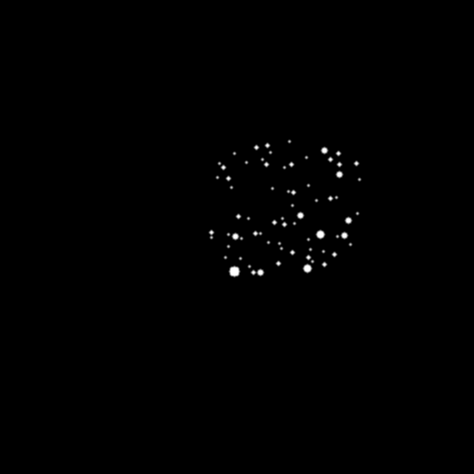

In [19]:
img = np.zeros((pixW,pixH))
dropletParams, nucParams = initialize_parameters()
dP , aX = domain_randomize(dropletParams,nucParams)

aX = convert_um_to_pixels(aX,pixelSize)

dropletParams[1] = convert_um_to_pixels(dropletParams[1],pixelSize)

print("Number of droplets:",dP[0])
print('Radius mean and var in pixels:',dP[1])
print("Minor and Major axes:",aX)
generate_droplet_image_bezier(img,aX,dP,padding = 60)

img = cv2.GaussianBlur(img,(3,3),0)
cv2_imshow(img)

## Reading in Real Data
1.Read in the .nd2 files for each cell <br>
2.Select appropriate channel <br>
3.Obtain the max intensity from the z-stack and convert to 0-255 range <br>
4.Write to .jpeg  <br>

In [20]:
!pip install pims_nd2
import pims_nd2 as nd2
import os

     |████████████████████████████████| 19.7 MB 1.1 MB/s 
     |████████████████████████████████| 82 kB 673 kB/s 
  Created wheel for pims-nd2: filename=pims_nd2-1.1-py3-none-any.whl size=19778399 sha256=92b7b431f3c4257741d031c381707d3cda7a6039beef060e0d2e90b0d3c22492
  Stored in directory: /root/.cache/pip/wheels/c4/5f/6a/c499ced897d109e21381e12a7acea883ea18fb0001434c0545
Successfully built pims-nd2
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2777088/45929032 bytes (6.0%)5603328/45929032 bytes (12.2%)8265728/45929032 bytes (18.0%)11460608/45929032 bytes (25.0%)14483456/45929032 bytes (31.5%)17612800/45929032 bytes (38.3

In [ ]:
realDatapath = '2022.01.31_Fixed Images/'
baseFilename = 'p88 TFH 5hr '
numFiles = len(os.listdir(realDatapath))

In [ ]:
#Iterate over every file in the specified directory
def read_nd2_to_jpg(path,filename,numFiles,outputpath,outname,chan):

    for i in range(1, numFiles + 1):
        #obtain the correct file label
        label = str(i)
        if len(str(i)) == 1:
            label = '00' + label
        elif len(str(i)) == 2:
            label = '0' + label

        img = nd2.ND2_Reader(path + filename + label + '.nd2' )
        img.bundle_axes = 'czyx'

        #Select channel, collapse z axis, convert intensity to 0-255 range
        channel = np.max(img[0][chan],axis = 0)
        diff = np.max(channel) - np.min(channel)
        channel = ((channel - np.min(channel))/diff * 255).astype(np.uint8)
        
        #Write images as jpg to outputpath folder
        cv2.imwrite(outputpath + outname  + f'{label}.jpg',channel)

        # #close reader
        img.close()
    
    print(".nd2 images converted to jpg and saved")

In [ ]:
read_nd2_to_jpg(realDatapath,baseFilename,5,"Image Synthesis/testA","real_",0)

Reading .nd2 images to jpg from GFP/mCherry channel 0/2 for training

In [ ]:
#GFP channel
channel = 0
read_nd2_to_jpg(realDatapath,baseFilename,numFiles,"Image Synthesis/trainA/","channel_0_",channel)

#mCherry channel
# channel = 2
# read_nd2_to_jpg(realDatapath,baseFilename,66,"Image Synthesis/trainA/","channel_2_",channel)


## Reading in Annotated Images as Test Data
Needed different code then reading in training data since it was time series of a single cell

In [ ]:
path = '2022.01.24 - Experimental Data with Manual Results/'
baseFilename = 'p88 TFH.nd2'
numFiles = 1

outpath = '/content/gdrive/MyDrive/Bioimage Informatics/Image Synthesis/test_general/'
outname = 'test_'

In [ ]:
reader = nd2.ND2_Reader('/content/gdrive/MyDrive/Bioimage Informatics/2022.01.24 - Experimental Data with Manual Results/p88 TFH.nd2' )
reader.bundle_axes
with nd2.ND2_Reader('/content/gdrive/MyDrive/Bioimage Informatics/2022.01.24 - Experimental Data with Manual Results/p88 TFH.nd2') as reader:
  
  for chan in range(reader.sizes['c']):
    i = 0
    for frame in reader:
      #Select channel, collapse z axis, convert intensity to 0-255 range
          proj = np.max(frame,axis = 0)
          diff = np.max(proj) - np.min(proj)
          proj = ((proj - np.min(proj))/diff * 255).astype(np.uint8)

          #Write images as jpg to outputpath folder
          if chan == 0:
            cv2.imwrite(outpath + 'GFP/' + outname  + f'c{chan}_t{i}.jpg',proj)
          elif chan == 1:
            cv2.imwrite(outpath + 'mCherry/' + outname  + f'c{chan}_t{i}.jpg',proj)

          i += 1

/usr/local/lib/python3.7/dist-packages/pims/base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


## Droplet Counting Using Connected Component Algorithm on Raw Images and Images Denoised/Enhanced using Traditional Methods

In [21]:
from cv2 import CV_16U, CV_32S, CV_8UC1,CC_STAT_AREA,connectedComponentsWithStats
import numpy as np
import pandas as pd
# Files util
import os
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

In [30]:
def file_index(names,chan):
    index= []
    for name in names:
        k = int(name.split('.')[0].split('test_')[-1].split(f'c{chan}_t')[-1])
        index.append(k)
    return index

def droplet_counting(dir,chan,processing = None):

    dF = pd.read_csv('/content/gdrive/MyDrive/Bioimage Informatics/2022.01.24 - Experimental Data with Manual Results/data.csv',sep='\t')
    
    tag = ''
    if chan == 0:
      tag = "GFP"
    elif chan == 1:
      tag = "mCherry"

    qty_csv = dF[dF.Channel == tag].Qty.tolist()
    ID_cdv = list(np.arange(0,len(qty_csv)))

    fileNames = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    indices = file_index(fileNames,chan)

    count =[]

    for i,filename in enumerate(os.listdir(dir)):
        f = os.path.join(dir, filename)
        # checking if it is a file

        cuurent_file = fileNames[i] 
        p = indices[i]
        

        if os.path.isfile(f):
            
            img = cv2.imread(f)
            img = np.array(img) 
            img = np.max(img,axis=0)
            diff = np.max(img) - np.min(img)
            img = (img-np.min(img))/diff
            img =(img * 255).astype(np.uint8)
            
            if processing == None:
              test = img
            elif processing == "baseline":
              clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(10, 10))
              test = clahe.apply(img)
              test = 255 - img
              test = cv2.fastNlMeansDenoising(test, None,5,11,21)
              test = cv2.adaptiveThreshold(test, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY_INV,11,21)
            
            num_labels, labels, stats, centroids = connectedComponentsWithStats(test, connectivity=8)


            output = img.copy()
            for j in range(1,num_labels):
                x = stats[j,cv2.CC_STAT_LEFT]
                y = stats[j,cv2.CC_STAT_TOP]
                w = stats[j,cv2.CC_STAT_WIDTH]
                h = stats[j,cv2.CC_STAT_HEIGHT]
                area = stats[j,cv2.CC_STAT_AREA]
                (cX, cY) = centroids[j]
                    
            output = cv2.rectangle(output, (x+2, y+2), (x+ w+2, y + h+2), (220, 20, 60), 1)   
            count.append(num_labels-1)
                
          
    print("CHANNEL",chan)
    dict1={}
    dict1 = dict(zip(indices,count))
    print("Calculated Droplet Counts")
    print(dict1)
    tuple_1 = sorted(dict1.items(), key=lambda x: x[0])
    x, y = zip(*tuple_1)
    dict2={}
    dict2 = dict(zip(ID_cdv,qty_csv))
    print("Actual Values")
    print(dict2)
    tuple_2 = sorted(dict2.items(), key=lambda x: x[0])
    z,w = zip(*tuple_2)
    
    return (x,y),(z,w)

In [33]:
dir = '/content/gdrive/MyDrive/Bioimage Informatics/Image Synthesis/testA'
rawInput, labels = droplet_counting(dir,1,processing = None)
baseline, _ = droplet_counting(dir,1,processing = 'baseline')

CHANNEL 1
Calculated Droplet Counts
{0: 3, 4: 2, 8: 3, 13: 4, 14: 2, 15: 2, 16: 3, 17: 2, 18: 4, 19: 4, 20: 2, 21: 2, 22: 2, 23: 2, 24: 1, 25: 2, 26: 3, 27: 3, 28: 2, 29: 3, 31: 2, 32: 1, 34: 1, 35: 2, 36: 3, 37: 3, 40: 2, 43: 2, 44: 4, 45: 2, 46: 4, 47: 3, 49: 5, 51: 5, 52: 4, 56: 7}
Actual Values
{0: 0, 1: 52, 2: 62, 3: 67, 4: 64, 5: 64, 6: 68, 7: 63, 8: 69, 9: 61, 10: 68, 11: 60, 12: 62, 13: 63, 14: 63, 15: 60, 16: 61, 17: 57, 18: 56, 19: 55, 20: 58, 21: 61, 22: 61, 23: 57, 24: 53, 25: 52, 26: 53, 27: 55, 28: 49, 29: 52, 30: 51, 31: 47, 32: 51, 33: 44, 34: 48, 35: 45, 36: 43, 37: 44, 38: 45, 39: 45, 40: 46, 41: 43, 42: 41, 43: 43, 44: 41, 45: 40, 46: 41, 47: 42, 48: 42, 49: 40, 50: 40, 51: 36, 52: 38, 53: 36, 54: 36, 55: 35, 56: 34, 57: 34, 58: 33, 59: 33}
CHANNEL 1
Calculated Droplet Counts
{0: 12, 4: 14, 8: 15, 13: 16, 14: 16, 15: 12, 16: 12, 17: 13, 18: 15, 19: 16, 20: 16, 21: 14, 22: 15, 23: 14, 24: 14, 25: 14, 26: 16, 27: 16, 28: 15, 29: 15, 31: 16, 32: 16, 34: 15, 35: 16, 36: 

## Droplet Counting Using Connected Component Algorithm on Denoised/Enhanced Images from passing Raw Images through trained Cycle GAN model


mCherry

In [34]:
epochs = 65
epochs = str(epochs) + " epochs"
exp = 'Evan_5_6_2_SSL'
outfile = f'/content/gdrive/MyDrive/Bioimage Informatics/denoise_results/{exp}/' + f'{epochs}_{exp}.jpg'
dir = f'/content/gdrive/MyDrive/Bioimage Informatics/denoise_results/{exp}/{epochs}/images'

In [35]:
def file_index(names,chan):
    index= []
    for name in names:
        k = int(name.split('.')[0].split('test_')[-1].split(f'c{chan}_t')[-1].split("_")[0])
        index.append(k)
    return index


chan = 1

fileNames = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) and f.split("_")[-1] != 'real']
indices = file_index(fileNames,chan)

count =[]

for i,filename in enumerate(os.listdir(dir)):
    f = os.path.join(dir, filename)
    # checking if it is a file

    cuurent_file = fileNames[i] 
    p = indices[i]
    

    if os.path.isfile(f) and filename.split("_")[-1] != 'real':
        
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        num_labels, labels, stats, centroids = connectedComponentsWithStats(img, connectivity = 8)

        output = img.copy()
        for j in range(1,num_labels):
            x = stats[j,cv2.CC_STAT_LEFT]
            y = stats[j,cv2.CC_STAT_TOP]
            w = stats[j,cv2.CC_STAT_WIDTH]
            h = stats[j,cv2.CC_STAT_HEIGHT]
            area = stats[j,cv2.CC_STAT_AREA]
            (cX, cY) = centroids[j]
                
        output = cv2.rectangle(output, (x+2, y+2), (x+ w+2, y + h+2), (220, 20, 60), 1)   
        count.append(num_labels-1)

print("CHANNEL",chan)
dict1={}
dict1 = dict(zip(indices,count))
print("Calculated Droplet Counts")
print(dict1)
tuple_1 = sorted(dict1.items(), key=lambda x: x[0])
x,y = zip(*tuple_1)
denoised = (x,y)

CHANNEL 1
Calculated Droplet Counts
{0: 86, 13: 69, 14: 69, 15: 71, 16: 73, 17: 71, 18: 71, 19: 71, 20: 66, 21: 71, 22: 63, 23: 61, 24: 68, 25: 69, 26: 69, 27: 68, 28: 68, 29: 64, 31: 63, 32: 60, 34: 64, 35: 65, 36: 64, 37: 63, 4: 76, 40: 62, 43: 59, 44: 58, 45: 59, 46: 61, 47: 60, 49: 58, 51: 57, 52: 60, 56: 53, 8: 75}


Plotting Results for Test Set

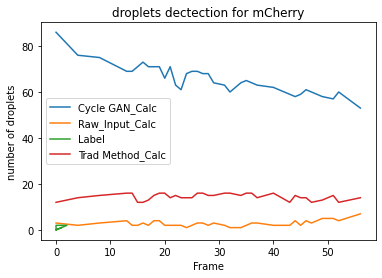

In [36]:
data = {"Cycle GAN_Calc" : denoised,  "Raw_Input_Calc" : rawInput, "Label" : labels, "Trad Method_Calc":baseline}

for key in data:
  plt.plot(data[key][0], data[key][1],label = key)
# for t, v in zip(x, y):
#       plt.text(t, v, str(v), fontsize=5)
plt.xlabel("Frame")
plt.ylabel("number of droplets")
plt.title(f"droplets dectection for mCherry")
plt.legend()
#plt.savefig(outfile)